# <center>Solar Panel Data Exploration</center>

Author: Sayantan Mitra<br>
Chief Data Scientist, Compton & Wendler<br>
Ph.D. candidate, Baylor College of Medicine

<div style="text-align: right">
*The Nation that leads in renewable energy will be the nation that leads the world* —James Cameron </div>

The 21st Century has borne witness to severe global environmental problems including polar ice-cap melting, frequent earthquakes in southeast Asia, and consequent tsunamis. Scientists have connected these problems to climate change. Across the globe, people have become more aware of the need for clean energy. The sun has been and will always remain the largest source of energy for the planet. Solar power has been harnessed in the last few decades but people have hesitated to adopt this capacity on a mass scale. Concerns range from solar energy's applicability and safety for residential homes to the amount of solar panels required to replace conventional energy sources.

In this project, I take a step toward demystifying the size of solar panels needed to completely eliminate reliance on traditional electricity. There are a lot of factors involved in efficient solar energy production and we will comprehensively address them throughout the project. Data for this project has been collected from [National Renewable Energy Laboratory](https://openpv.nrel.gov/search).

## ► <span  style="color:blue; font-size:15px"> Objective: Predict size of solar panels for residential setting
## ► <span  style="color:blue; font-size:15px"> Objective: Predict cost of solar panels for residential setting</span>

Here is a video to learn how home solar panels work! 

[![How Home Solar Panel Works](http://img.youtube.com/vi/m6UgO6-HELc/0.jpg)](http://www.youtube.com/watch?v=m6UgO6-HELc) 

# Contents of the Notebook:

# 1. Exploratory Data Analysis (EDA)

# 1.A. Import libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pf
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# 1.B. Load data 
We can have basic information of the columns and about data overall, stored in the form of a dictionary.

In [2]:
pd.options.display.max_colwidth = 100
solar_dictionary = pd.read_excel('solar_sizepred_datadict.xlsx', index_col='Column Names')
solar_dictionary

,Description
Column Names,
state,Which state the customer belongs
date_installed,How long ago it has been installed
incentive_prog_names,Incentive programs specific to the states
size_kw,Size of the solar panels installed (TARGET)
zipcode,customers zipcode
install_type,customers pupose of installation
installer,Installing company for solar panels
city,Which city customer belongs to
tech_1,Different types of solar panels that determins solar panel quality


In [3]:
solar = pd.read_csv('solar_sizepred.csv', parse_dates=['date_installed']) 
solar.head()

,state,date_installed,incentive_prog_names,size_kw,zipcode,install_type,installer,city,tech_1,county,annual_PV_prod,annual_insolation,tracking_type
0,TX,2013-12-12,Austin Energy,10.56,78702,residential,NaN,AUSTIN,Poly,Travis,14999.831600,5.157692,Fixed
1,TX,2014-07-11,Austin Energy,12.72,78702,residential,NaN,AUSTIN,Mono,Travis,17811.574390,5.085633,Fixed
2,TX,2014-01-17,Austin Energy,5.40,78702,residential,NaN,AUSTIN,Mono,Travis,7833.742822,5.262714,Fixed
3,TX,2012-09-27,Austin Energy,7.50,78702,residential,NaN,AUSTIN,Poly,Travis,10151.709590,4.920972,Fixed
4,TX,2012-09-26,Austin Energy,5.00,78702,residential,NaN,AUSTIN,Poly,Travis,7307.133789,5.304778,Fixed


In [4]:
# Overall statistics of the numerical columns
solar.describe(percentiles=[.25,.5,.75,.9,.975])

,size_kw,zipcode,annual_PV_prod,annual_insolation
count,542618.000000,542618.000000,5.426180e+05,542618.000000
mean,11.612236,68646.935190,1.674957e+04,5.264753
std,80.877078,37362.444983,1.094119e+05,0.765272
min,0.050000,1001.000000,8.765472e+01,1.177450
25%,3.900000,19426.500000,5.640710e+03,4.544056
50%,5.640000,91342.000000,8.251434e+03,5.374999
75%,8.041338,93274.000000,1.173740e+04,5.685442
90%,11.000000,95066.000000,1.636997e+04,6.497946
97.5%,27.540000,95765.000000,3.966079e+04,6.510539
max,5999.930000,97914.000000,9.300156e+06,6.761269


We will only select residential data and upto 40 Kw. For residential setting people will install as big as 40kw. Any bigger installation are generally anomaly based on record-research. 

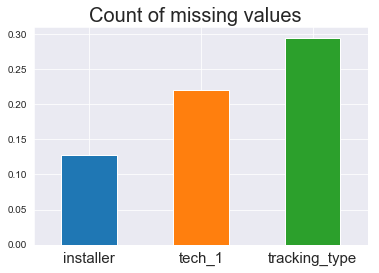

In [5]:
# Range of residential is upto 40kWh generally
filt1 = solar['install_type'] == 'residential'
filt2 = (solar['size_kw'] > 0) & (solar['size_kw'] < 40)
solar = solar[filt1 & filt2]
# All residential so drop column 'install_type'
solar = solar.drop(columns=['install_type'])
solar.shape

# Check missing values
solar.isna().mean().round(3)
f,ax=plt.subplots(figsize=(6,4))
missing = solar.isna().mean()
missing[missing>0].plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=15)
f.suptitle('Count of missing values', fontsize=20, y=.95);

♦ **Initial observation:**
`installer`, `tech_1`, and `tracking_type` columns contain missing values. Here we will replace them with `Unknown`

In [6]:
# Check whether the missing value might have any predictive power
# Using median as 'size_kw' is not gaussian distribution
a = solar.dropna()['size_kw'].median()
b = solar.loc[solar['installer'].isna(),['size_kw']].median()[0].round(2)
c = solar.loc[solar['tech_1'].isna(),['size_kw']].median()[0].round(2)
d = solar.loc[solar['tracking_type'].isna(),['size_kw']].median()[0].round(2)

print(f'Overall solar panel size in residential housing without missing values: {a}\n')
print(f'Overall solar panel size in when installer data is missing: {b}\n')
print(f'Overall solar panel size in when tech_1 data is missing: {c}\n')
print(f'Overall solar panel size in when tracking_type data is missing: {d}\n')

Overall solar panel size in residential housing without missing values: 5.39

Overall solar panel size in when installer data is missing: 6.27

Overall solar panel size in when tech_1 data is missing: 6.21

Overall solar panel size in when tracking_type data is missing: 5.94



Missing values could be predictive, so we can create a separate missingness capture column. This is specially useful when monotonic relatiosnhip is generated between categorial column and target during categorical encoding. However missingness capture column doesnt improve the prediction performance, so I took it out.

In [7]:
# capture missingness of data
def impute_na(df, col):
    #df[col + '_NA'] = np.where(df[col].isna(), 1, 0) 
    df[col].fillna("Unknown", inplace=True)
    
cols = ['installer', 'tech_1', 'tracking_type']
for col in cols:
    impute_na(solar, col)
print(f'Missing values after imputation: {solar.isna().sum().sum()}')

Missing values after imputation: 0


# 1.C. Feature Engineering

In [8]:
# Zipcode: extract initial numbers of zipcode to see impact on energy production if area is classified largely
solar['zipcode_1'] = solar['zipcode'].astype('str').str[:1].astype(int)
# DateTime column: extract year and month of installation
date = solar['date_installed']
solar['year'] =  date.dt.year
solar['month'] = date.dt.month

# solar_x will be a copy of the data at this stage (before taking care of cardinality)
solar_x = solar.copy()
solar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487253 entries, 0 to 542617
Data columns (total 15 columns):
state                   487253 non-null object
date_installed          487253 non-null datetime64[ns]
incentive_prog_names    487253 non-null object
size_kw                 487253 non-null float64
zipcode                 487253 non-null int64
installer               487253 non-null object
city                    487253 non-null object
tech_1                  487253 non-null object
county                  487253 non-null object
annual_PV_prod          487253 non-null float64
annual_insolation       487253 non-null float64
tracking_type           487253 non-null object
zipcode_1               487253 non-null int32
year                    487253 non-null int64
month                   487253 non-null int64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(7)
memory usage: 57.6+ MB


In [9]:
# Divide data into train and test # Use this test as a validation set later on
solar_train, solar_val = train_test_split(solar, test_size=0.2, random_state= 0)
solar = solar_train

### Cardinality reduction

In [10]:
solar.describe(include=['O']).T

,count,unique,top,freq
state,389802,19,CA,209433
incentive_prog_names,389802,47,California Public Utilities Commission (California Solar Initiative),112684
installer,389802,5960,SolarCity,90439
city,389802,7568,TUCSON,7736
tech_1,389802,12,Poly,175819
county,389802,479,Los Angeles,37370
tracking_type,389802,5,Fixed,273985


► Unique values in some categorical columns such as `installer`, `city`, `county`, etc. are large. Generally cardinality leads to more problems in tree based models. We will only retain the categories in a categorical column that has 1% or more appearances. The remaining categories in that column will be aggregated as `Others`. This process will be done for both the train and test set.

In [11]:
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)

df, patterns, reduced_list, other = group_levels_in_categoricals(solar)
# solar training set after transformation
solar.describe(include=['O']).T

,count,unique,top,freq
state,389802,12,CA,209433
incentive_prog_names,389802,18,California Public Utilities Commission (California Solar Initiative),112684
installer,389802,12,Other,179191
city,389802,7,Other,354837
tech_1,389802,5,Poly,175819
county,389802,23,Other,125813
tracking_type,389802,3,Fixed,273985


In [12]:
# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):  
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test

solar_val = group_levels_in_categoricals_test(reduced_list, other, patterns, solar_val)
# solar validation set after transformation
solar_val.describe(include=['O']).T

,count,unique,top,freq
state,97451,12,CA,52440
incentive_prog_names,97451,18,California Public Utilities Commission (California Solar Initiative),28136
installer,97451,12,Others,44943
city,97451,7,Others,88833
tech_1,97451,5,Poly,44016
county,97451,23,Others,31327
tracking_type,97451,3,Fixed,68409


♦ Solar train and validation set's categorical columns have the same number of unique values.

In [13]:
# Overall summary of the dataset
pf.ProfileReport(solar)

Number of variables,16
Number of observations,389802
Total Missing (%),0.0%
Total size in memory,46.1 MiB
Average record size in memory,124.0 B
Numeric,6
Categorical,7
Boolean,0
Date,1
Text (Unique),0
Rejected,2


# 2.A. Explore target variable: `size_kw`

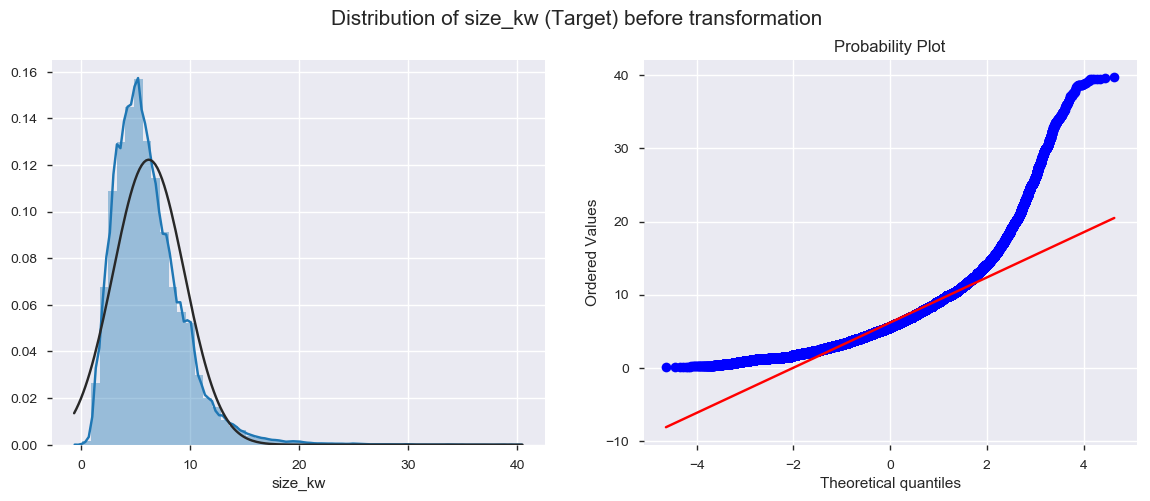

mu = 6.18 and sigma = 3.26

Skewness: 1.738892
Kurtosis: 7.025893
The target variable is right skewed. We need to transform the target before running regression.




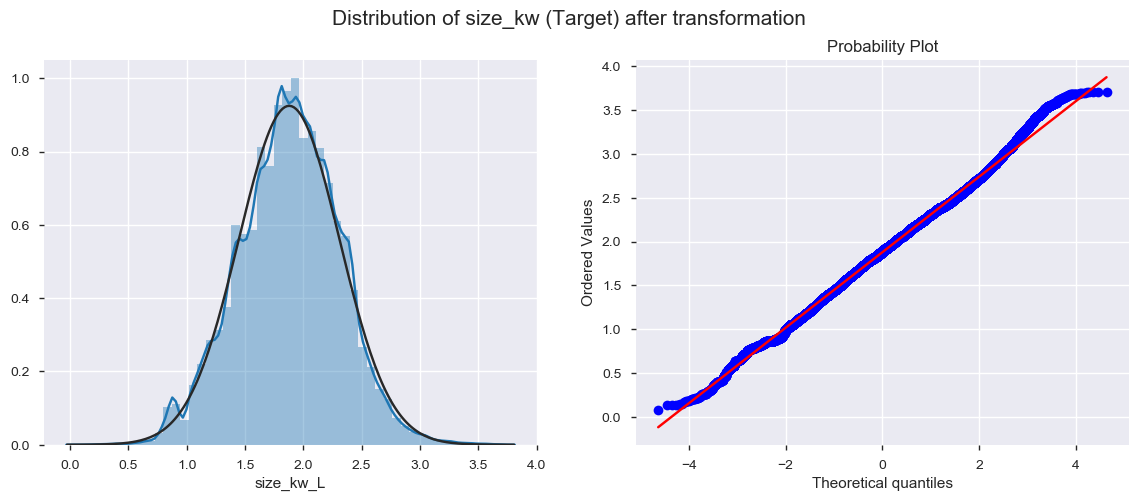


 mu = 1.88 and sigma = 0.43

Skewness: -0.040941
Kurtosis: 0.122032
After transformation target follows normal distribution.


In [14]:
import scipy.stats as st
from scipy.stats import norm, skew 
fig, axes = plt.subplots(1,2, figsize = (14,5))

# Distribution of target
sns.distplot(solar['size_kw'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['size_kw'], plot=plt)
fig.suptitle('Distribution of size_kw (Target) before transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['size_kw'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['size_kw'].skew())
print("Kurtosis: %f" % solar['size_kw'].kurt())
print(f'The target variable is right skewed. We need to transform the target before running regression.')
print('\n')


# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
solar['size_kw_L'] = np.log1p(solar['size_kw'])
solar_val['size_kw_L'] = np.log1p(solar_val['size_kw'])
fig, axes = plt.subplots(1,2, figsize = (14,5))

#Check the new distribution 
sns.distplot(solar['size_kw_L'], fit=norm, ax=axes[0])
# QQ-plot to check normality
res = st.probplot(solar['size_kw_L'], plot=plt)
fig.suptitle('Distribution of size_kw (Target) after transformation', size=15)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['size_kw_L'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['size_kw_L'].skew())
print("Kurtosis: %f" % solar['size_kw_L'].kurt())
print(f'After transformation target follows normal distribution.')

# 2.B. Analysis of individual features

## Types of Features
The 2 broad classes of variables in the dataset are categorical and continuous.

### Categorical Features:
A categorical variable is one that is limited to a finite number of categories. Categories can be labels or discrete numerical values. For example, gender is a categorical variable having two categories (male and female). Categorical features can be further divided into ordinal and nominal data.

• **Ordinal data** has a natural ordering but the difference between the orders is not measurable. For example, stage 4 cancer is worse than stage 3 (an order), but we cannot quantify how much worse. <br>
• **Nominal data** are categorical data without any natural ordering. For example, all available hair color dyes.<br>
► Categorical features in the dataset are updated in the data dictionary below.
### Continuous Features:
A continuous variable can take an infinite set of numerical values. <br>
► Continuous features in the dataset are updated in the data dictionary below.

In [15]:
# select features with <20 unique elements as categories 
solar.nunique()

state                       12
date_installed            4426
incentive_prog_names        18
size_kw                  16837
zipcode                   7535
installer                   12
city                         7
tech_1                       5
county                      23
annual_PV_prod          244308
annual_insolation        61450
tracking_type                3
zipcode_1                    8
year                        17
month                       12
size_kw_L                16837
dtype: int64

In [16]:
# update data dictionary about feature type
solar_dictionary.drop(solar_dictionary.index[5:6], inplace=True)
solar_dictionary.loc['month']= 'month of installation'
solar_dictionary.loc['year']= 'year of installation'
solar_dictionary.loc['zipcode_1']= '1st number of zipcode'

c, o, n, d = 'continuous', 'ordinal', 'nominal', 'datetime'
d = {'size_kw':c, 'annual_PV_prod':c, 'annual_insolation':c, 'zipcode':o, 'zipcode_1':o, 
     'year':o, 'month':o, 'tech_1':o, 'date_installed': d, 'state': n, 'city': n, 'county': n,
    'incentive_prog_names': n, 'installer': n, 'tracking_type':n}
solar_dictionary['Feature Info'] = pd.Series(d)
solar_dictionary

,Description,Feature Info
Column Names,,
state,Which state the customer belongs,nominal
date_installed,How long ago it has been installed,datetime
incentive_prog_names,Incentive programs specific to the states,nominal
size_kw,Size of the solar panels installed (TARGET),continuous
zipcode,customers zipcode,ordinal
installer,Installing company for solar panels,nominal
city,Which city customer belongs to,nominal
tech_1,Different types of solar panels that determins solar panel quality,ordinal
county,Customers county,nominal


# 2.C. Analyzing numerical features

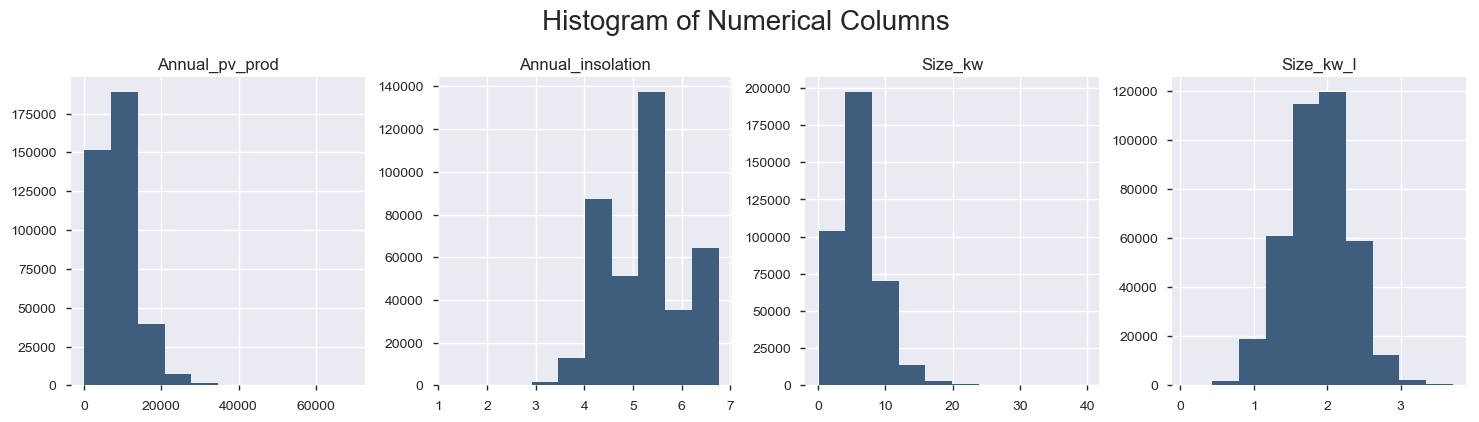

In [17]:
# Select numerical columns
solar_num = solar.select_dtypes(include=['number'])
solar_num = solar_num[['annual_PV_prod', 'annual_insolation', 'size_kw', 'size_kw_L']]
# EDA: Distribution of individual numerical features
fig, axes = plt.subplots(1,4, figsize=(18,4), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
axes = axes.ravel()
st = fig.suptitle('Histogram of Numerical Columns', fontsize = 20)
st.set_y(1.05)

for i in range(solar_num.shape[1]):
    axes[i].hist(solar_num.iloc[:, i],color = '#3F5D7D')
    axes[i].set_title(solar_num.columns[i].capitalize())

fig.tight_layout()

♦ **Initial observation:** <br>
→ `size_kw` follows normal distribution once it has been log transformed (`size_kw_L`). <br>
→ `Annual_insolation` and `annual_PV_prod` are not normally distributed. **For linear model, one of the assumption is to have predictors in the gaussian distribution. Thus, we need to transform `annual_PV_prod` (as it is a good predictor) feature into a gaussian distribution.**<br>

## `annual_PV_prod`: Annual photovoltaic energy production

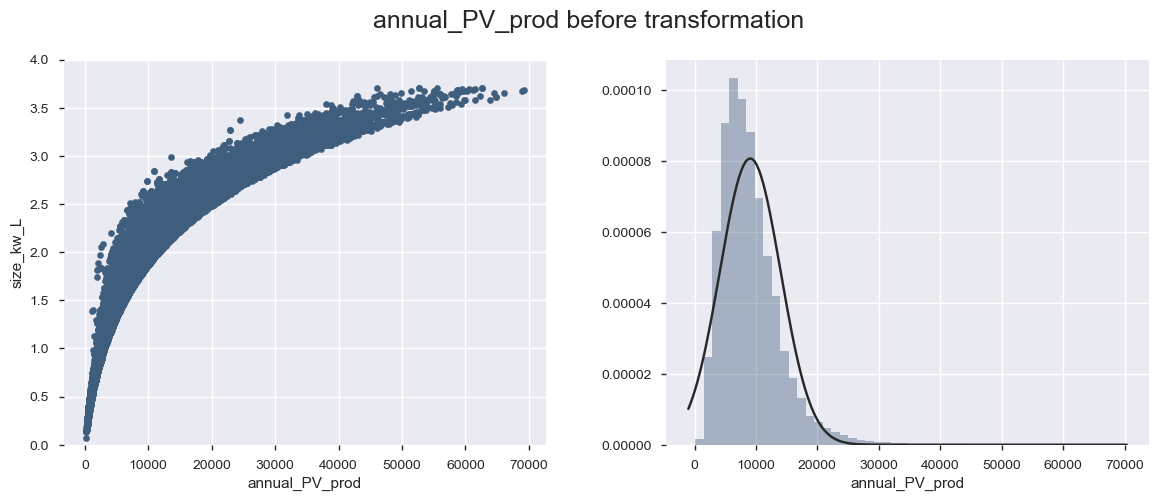

mu = 9059.55 and sigma = 4940.85

Skewness: 1.916084
Kurtosis: 8.070087


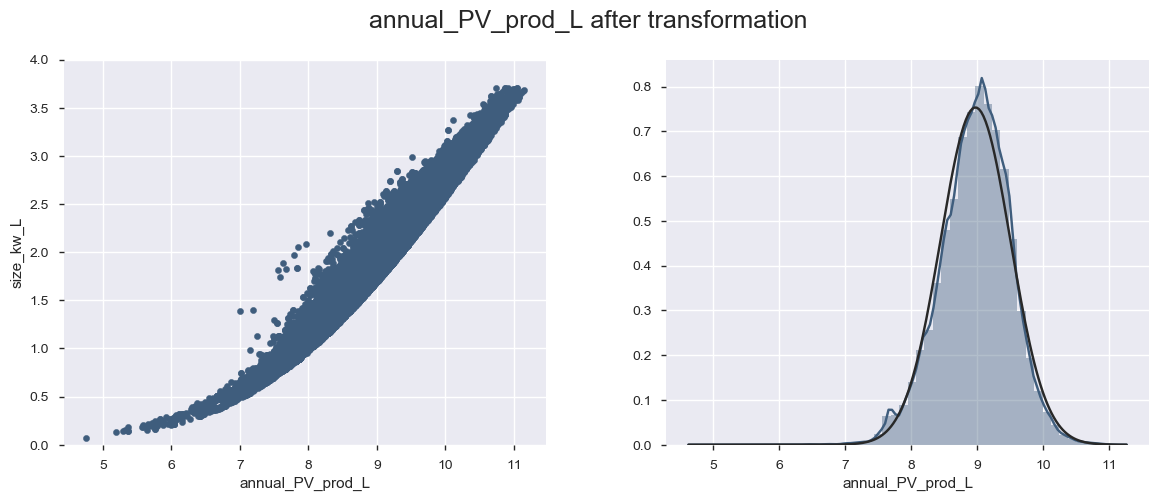

mu = 8.98 and sigma = 0.53
Skewness: -0.285053
Kurtosis: 0.587433


In [18]:
fig, axes = plt.subplots(1,2, figsize = (14,5), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
solar.plot.scatter(x='annual_PV_prod', y='size_kw_L', ylim=(0,4), color = '#3F5D7D', ax=axes[0])
# Distribution of annual_PV_prod
sns.distplot(solar['annual_PV_prod'], kde=False, fit=norm, ax=axes[1], color = '#3F5D7D')
fig.suptitle('annual_PV_prod before transformation', size=18)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['annual_PV_prod'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
print("Skewness: %f" % solar['annual_PV_prod'].skew())
print("Kurtosis: %f" % solar['annual_PV_prod'].kurt())

fig, axes = plt.subplots(1,2, figsize = (14,5), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
# numpy fuction log1p applies log(1+x) to all elements of the column
solar['annual_PV_prod_L'] = np.log1p(solar['annual_PV_prod'])
solar_val['annual_PV_prod_L'] = np.log1p(solar_val['annual_PV_prod'])
solar.plot.scatter(x='annual_PV_prod_L', y='size_kw_L', ylim=(0,4), color = '#3F5D7D', ax=axes[0])
# Distribution of the transformed column
sns.distplot(solar['annual_PV_prod_L'], fit=norm, ax=axes[1], color = '#3F5D7D')
fig.suptitle('annual_PV_prod_L after transformation', size=18)
plt.show()
# Skewness and Kurtosis
(mu, sigma) = norm.fit(solar['annual_PV_prod_L'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print("Skewness: %f" % solar['annual_PV_prod_L'].skew())
print("Kurtosis: %f" % solar['annual_PV_prod_L'].kurt())

→ log transformation of `annual_PV_prod` ensured it to follow the normal distribution. 

## `annual_insolation`: Amount of solar radiation falling on a particular area

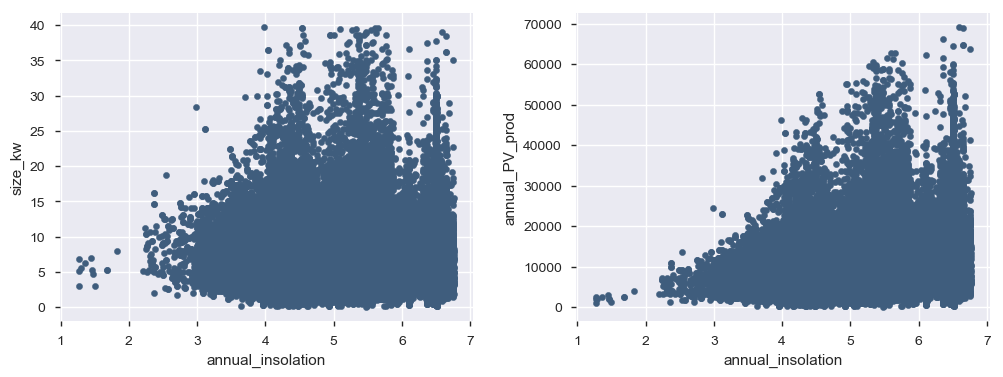

In [19]:
f, ax = plt.subplots(1,2, figsize=(12,4), gridspec_kw = {'wspace':0.25, 'hspace':0.30})
solar.plot.scatter(x='annual_insolation', y='size_kw', ax=ax[0], color = '#3F5D7D')
solar.plot.scatter(x='annual_insolation', y='annual_PV_prod', ax=ax[1], color = '#3F5D7D');

♦ **Initial observation:** <br>

→ Insolation's relation with `size_kw` is not clear from the data (because although the size of solar panel installed can be dependent on solar radiation in a particular area, it is more likely to be based on the energy consumption in that particular household). <br>

→ As expected with an increase in `annual_insolation`, `annual_PV_prod` increases. So to produce the same amount of energy, an area with higher insolation will need to install less `size_kw` and vice versa. However, we see a large range of the amount of energy production at higher insolation. This disparity might be due to how many solar panels are installed, the quality of solar panel efficiency in producing energy, etc.

# 2.D. Column-wise relationship

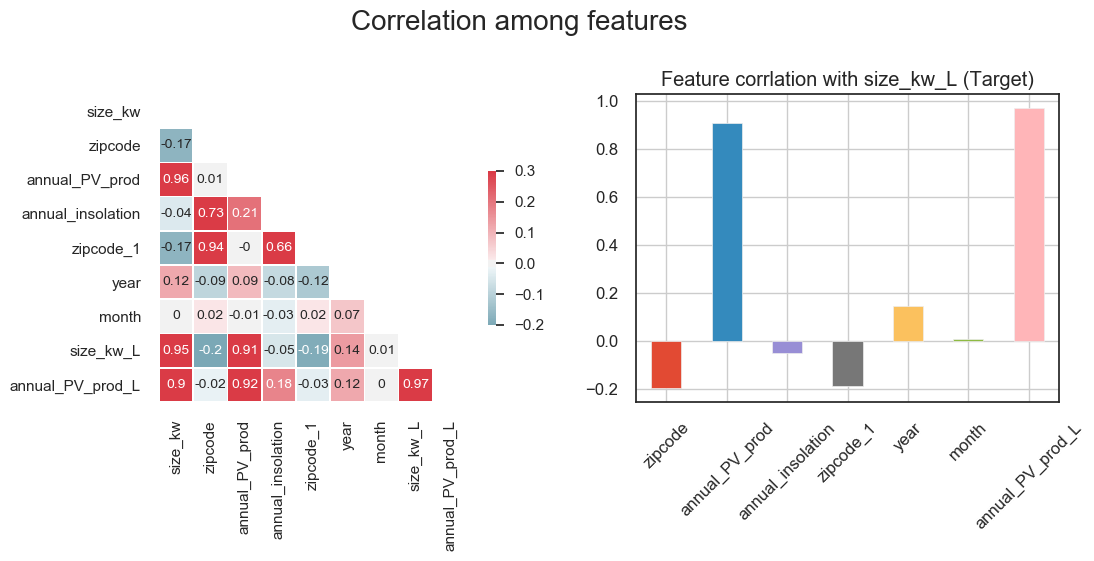

In [20]:
# EDA: Correlation matrix among all features will inform us relationship between features
sns.set(style='white', font_scale = 1)
fig, axes = plt.subplots(1,2, figsize = (16,8))
# Correlation matrix
corr = solar.corr().round(2)
# Generate mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig.suptitle('Correlation among features', x=0.45, y=1.09, fontsize = 20)

# Generate custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, annot_kws={'size': 10}, mask=mask, cmap=cmap, vmax=.3, 
                                    center=0, square=True, linewidths=.5, 
            cbar_kws={'shrink':.5}, ax=axes[0]);

# EDA: Correlation with target
plt.style.use('ggplot')
solar2 = solar.drop(columns=['size_kw', 'size_kw_L']) #, 'annual_PV_prod_L'
solar2.corrwith(solar['size_kw_L']).plot.bar(figsize=(12,4),
                                               title = 'Feature corrlation with size_kw_L (Target)',
                                               fontsize = 12, rot = 45);

# 2.E. Analyzing categorical features

## `year`: year of installation of solar panels

In [21]:
solar.pivot_table(index='year', columns='month', values='size_kw', 
                               fill_value=0, aggfunc='size').style.background_gradient(cmap='summer_r')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1999,0,0,0,5,0,0,0,1,792,1,0,5
2000,10,4,5,2,5,0,0,4,1,1,3,4
2001,5,12,14,14,16,12,17,14,8,24,17,19
2002,19,19,33,23,19,24,31,50,46,74,50,60
2003,40,28,24,20,18,37,28,26,52,49,45,38
2004,44,37,29,49,54,48,73,72,61,48,68,68
2005,84,50,94,64,75,116,106,105,125,112,130,200
2006,147,122,151,142,166,179,155,190,152,188,164,185
2007,121,115,169,178,263,368,438,551,609,710,703,739


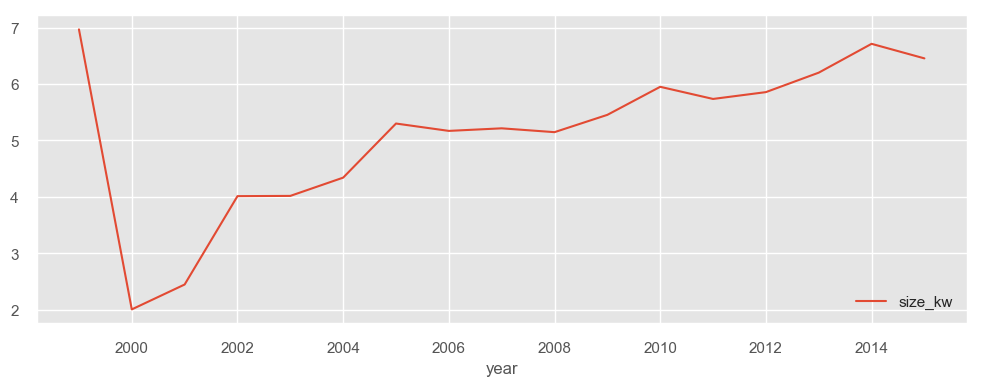

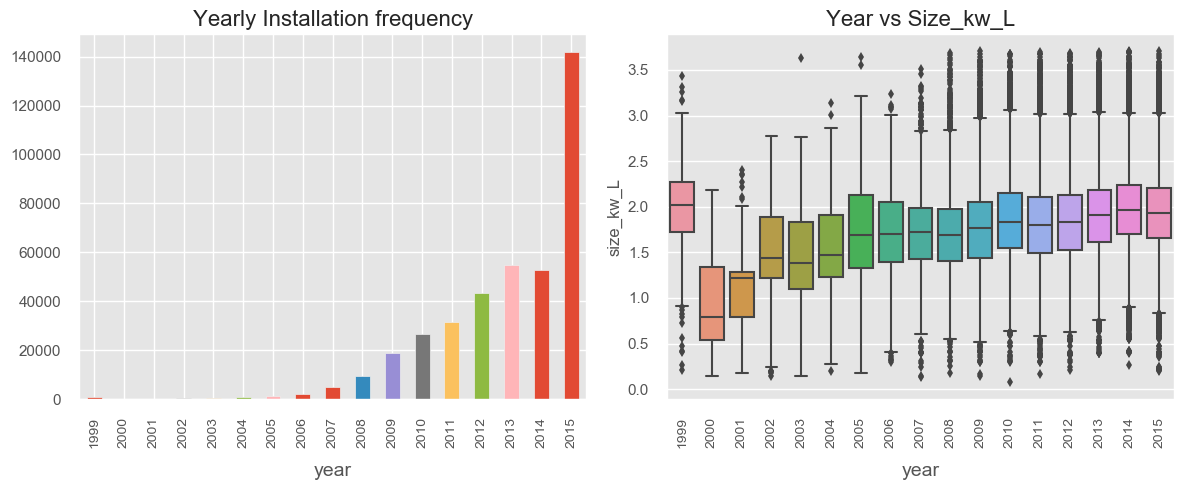

In [22]:
f,ax = plt.subplots(figsize=(12,4))
solar_year = solar.groupby('year').agg({'size_kw':'mean'})
solar_year.plot(ax=ax)


def value_count_plot(data, col, sort, ascending, ax, xlabel, title, size, fontsize, font, rotation=0):
    data[col].value_counts(sort=sort).plot.bar(ax=ax)
    ax.set_xlabel(xlabel, fontsize = font, labelpad = 10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, rotation = rotation)
    ax.set_title(title, size=size)
    
def cat_box_plot(x, y, data, ax, xlabel, title, size, fontsize, font, rotation=0):
    sns.boxplot(x, y, data=data, ax=ax)
    ax.set_title(title, size=size)
    ax.set_xlabel(xlabel, fontsize = font, labelpad = 10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize, rotation = rotation)
    plt.tight_layout()
    plt.show()
    
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='year', sort=False, ascending=False, ax=ax[0], 
                 xlabel='year', title='Yearly Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'year', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='year', 
                     title='Year vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Overall, the number of installations have increased over the years. <br>

→ The size of the installations have also increased from the initial years (except 1999). 

# `month`: installation month of solar panels

In [23]:
solar.pivot_table(index='month', columns='state', values='size_kw', aggfunc='size').style.background_gradient(cmap='summer_r')

state,AZ,CA,CT,MA,MD,NJ,NM,NV,NY,Other,PA,TX
month,,,,,,,,,,,,
1,3719,13730,724,2306,343,445,179,680,2287,437,479,331
2,3401,12035,591,2166,303,323,242,544,2072,451,295,310
3,3704,12099,707,2770,353,378,271,481,2385,502,280,273
4,3634,12433,701,3376,397,424,266,490,2441,570,329,293
5,3836,13870,716,3723,415,372,273,829,2301,549,391,269
6,3822,15724,907,3878,421,516,327,739,2245,811,433,341
7,3991,18932,982,4397,453,487,319,790,1976,716,419,380
8,4040,20663,996,4315,445,453,379,1088,2533,627,494,413
9,4922,20588,1158,4907,418,435,345,926,2749,765,384,556


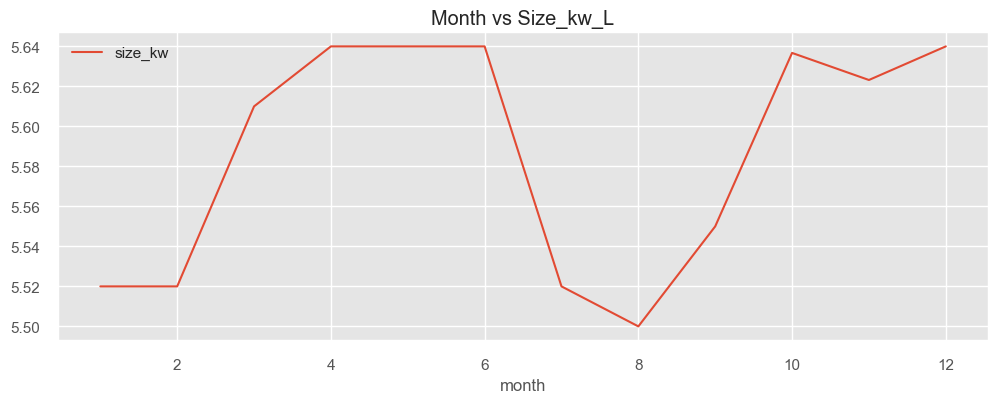

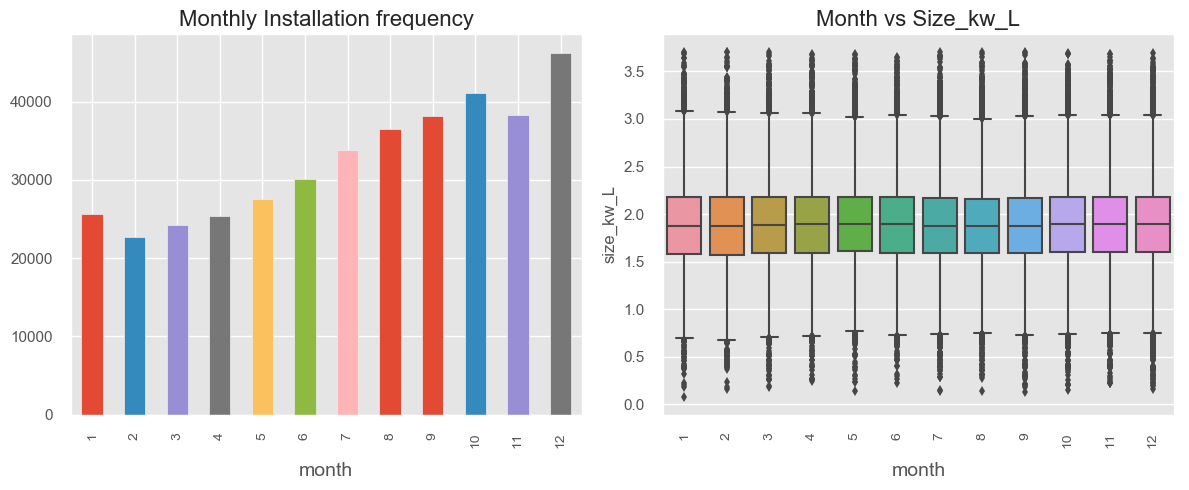

In [24]:
f,ax = plt.subplots(figsize=(12,4))
solar_year = solar.groupby('month').agg({'size_kw':'median'})
solar_year.plot(ax=ax)
ax.set_title('Month vs Size_kw_L')

f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='month', sort=False, ascending=False, ax=ax[0], 
                 xlabel='month', title='Monthly Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'month', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='month', 
                     title='Month vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ The number of installations are generally higher during December. <br>

→ The size of solar panels installed is not affected by the month of installation.

→ When we explore statewide installation,  MA, MD, and NJ show a different trend that the rest of the states in the number of solar panel installations over different months.

# `state`

In [25]:
def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

df.pivot_table(index='year', columns='state', values='size_kw', aggfunc='size', 
                               fill_value=0).style.apply(highlight_max)

state,AZ,CA,CT,MA,MD,NJ,NM,NV,NY,Other,PA,TX
year,,,,,,,,,,,,
1999,792,7,0,0,0,0,0,0,0,5,0,0
2000,7,5,0,0,0,0,0,0,2,25,0,0
2001,0,112,0,1,0,3,0,0,8,44,0,4
2002,21,226,0,0,0,19,0,0,137,39,6,0
2003,51,52,0,42,0,52,0,0,144,43,21,0
2004,80,40,0,82,0,183,0,3,163,53,16,31
2005,139,111,26,42,18,511,0,43,157,49,68,97
2006,302,227,70,147,32,557,0,48,326,119,4,109
2007,279,3189,132,142,0,415,0,73,500,99,7,128


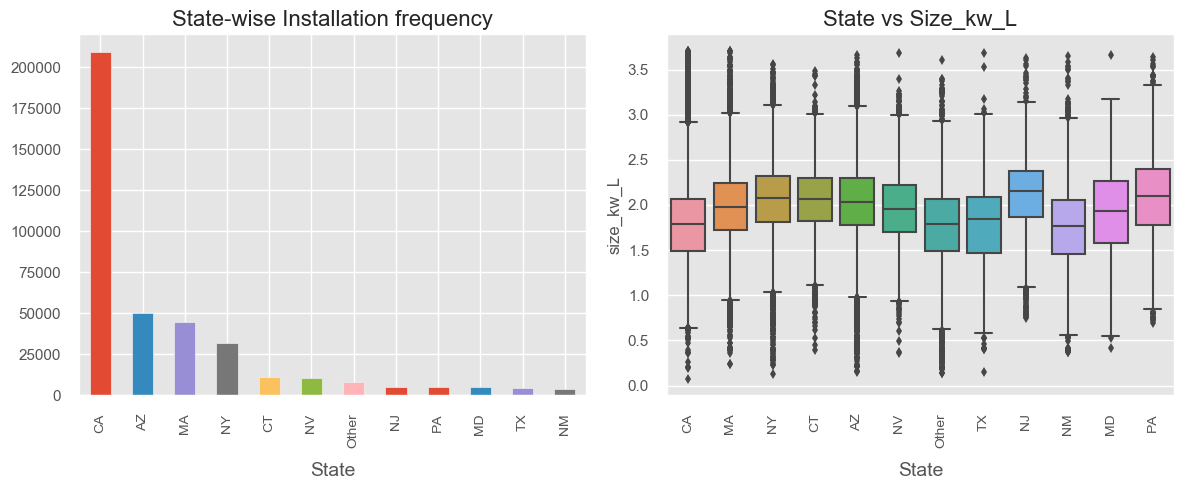

In [26]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='state', sort=True, ascending=False, ax=ax[0], 
                 xlabel='State', title='State-wise Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'state', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='State vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Overall, the number of installations and the size of installations have increased over the years in different states.  <br>

→ Although CA has the most installations, the mean size of solar panel installation in CA is less than most of the states.

## `zipcode_1`: 1st number from zipcode representing a larger area

In [27]:
solar.groupby('zipcode_1').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

In [28]:
df.pivot_table(index='zipcode_1', columns='year', values='size_kw', 
                       fill_value=0, aggfunc='size').style.apply(highlight_max)

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
zipcode_1,,,,,,,,,,,,,,,,,
1,0,2,9,143,181,212,248,441,642,869,1842,3880,3783,3993,6423,13136,28182
2,0,0,0,0,29,50,38,90,56,216,763,686,1031,2059,3033,5203,11433
3,0,0,0,1,0,0,0,7,17,54,548,554,123,182,224,405,892
5,0,0,0,12,16,45,33,69,7,77,130,0,41,129,99,198,239
6,0,0,0,0,0,0,26,70,132,211,369,363,311,483,979,2486,6028
7,0,0,6,6,13,101,291,320,265,333,486,700,626,578,627,647,893
8,792,7,1,34,90,196,499,696,630,857,2802,5299,5684,8006,9583,11467,22082
9,12,30,156,252,76,47,126,248,3215,6923,11910,15017,19877,27839,33648,19341,72235


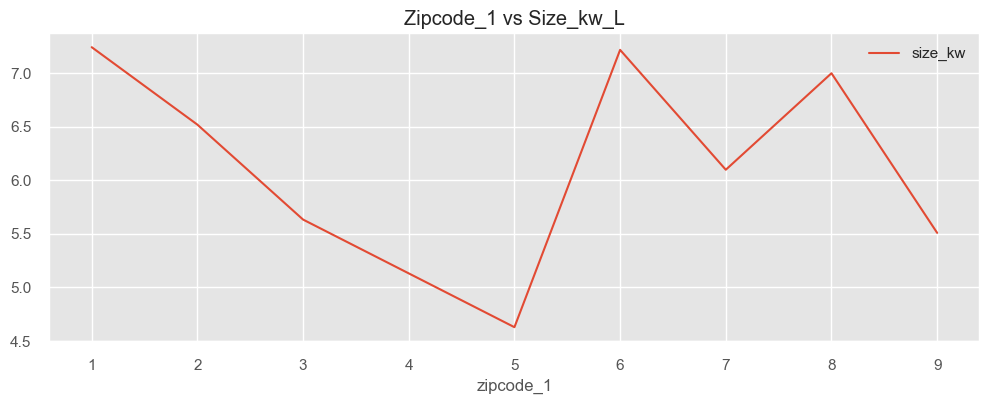

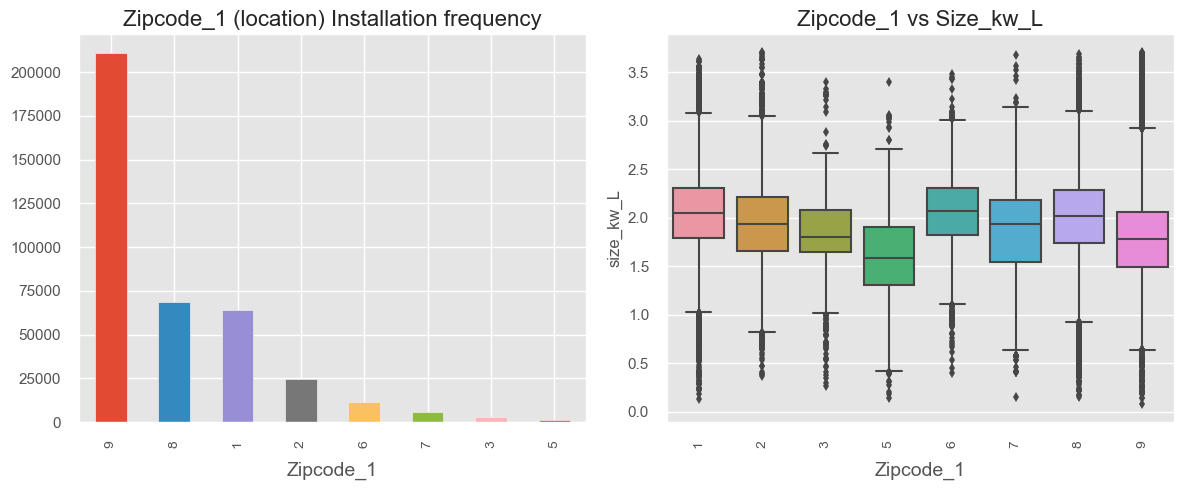

In [29]:
f,ax = plt.subplots(figsize=(12,4))
solar_year = solar.groupby('zipcode_1').agg({'size_kw':'mean'})
solar_year.plot(ax=ax)
ax.set_title('Zipcode_1 vs Size_kw_L')

f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='zipcode_1', sort=True, ascending=False, ax=ax[0], 
                 xlabel='Zipcode_1', title='Zipcode_1 (location) Installation frequency',size=16, fontsize=10, font=14, rotation=90)

cat_box_plot(x='zipcode_1', y='size_kw_L',data=solar, ax=ax[1], xlabel='Zipcode_1', 
                     title='Zipcode_1 vs Size_kw_L',size=16,fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ Overall, zipcode (with 1st number) 9 has installed the most solar panels over the years. <br>

→ The size of the solar panels installed are lowest in the area of zipcode starting with 5.

# `Installer`: installing company for solar panels

In [30]:
solar.groupby('installer').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

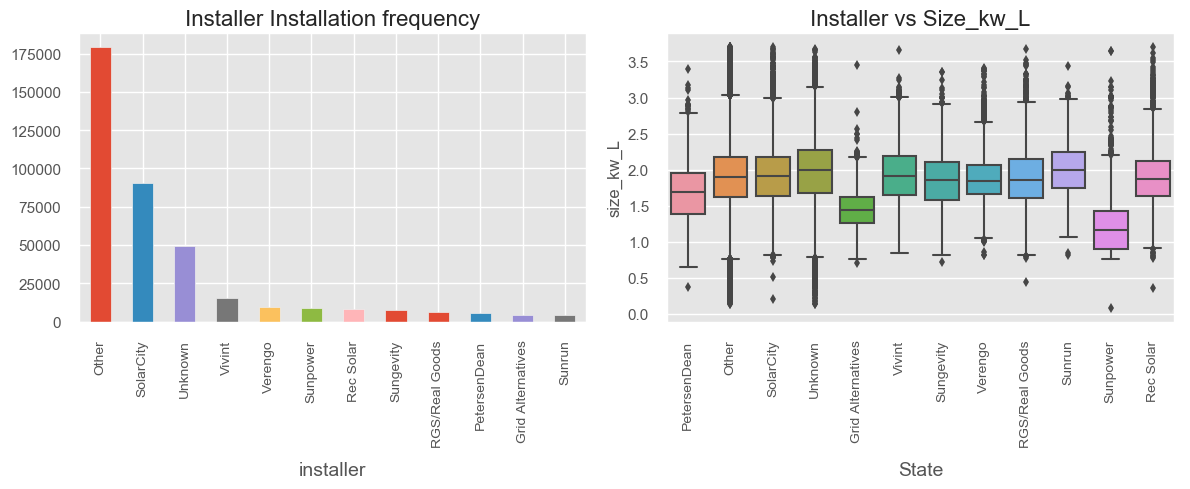

In [31]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='installer', sort=True, ascending=False, ax=ax[0], 
                 xlabel='installer', title='Installer Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'installer', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='Installer vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ There were several companies over all these states who are officially registered to install solar panels. But the installation companies that have installed less than 1% of the total solar panels are aggregated as `others`.   <br>

→ The largest solar panels are installed by a company `Sunrun`. The most installations are done by `Solarcity`.

# `Tech_1`: different types of solar panels 

In [32]:
solar.groupby('tech_1').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

In [33]:
df.pivot_table(index='tech_1', columns='year', values='size_kw', 
                       fill_value=0, aggfunc='size').style.apply(highlight_max)

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
tech_1,,,,,,,,,,,,,,,,,
Mono,2,0,3,0,2,52,98,134,1200,2989,6365,10763,13229,18009,17608,12200,36527
Other,0,0,0,0,0,2,50,57,342,554,1272,958,565,232,87,32,457
Poly,0,0,2,7,25,90,158,410,1900,4097,7438,9664,11593,17886,29021,23817,69711
Unknown,802,39,167,440,378,507,952,1339,1515,1898,3740,4985,5800,6907,7624,15985,32498
crystalline,0,0,0,1,0,0,3,1,7,2,35,129,289,235,276,849,2791


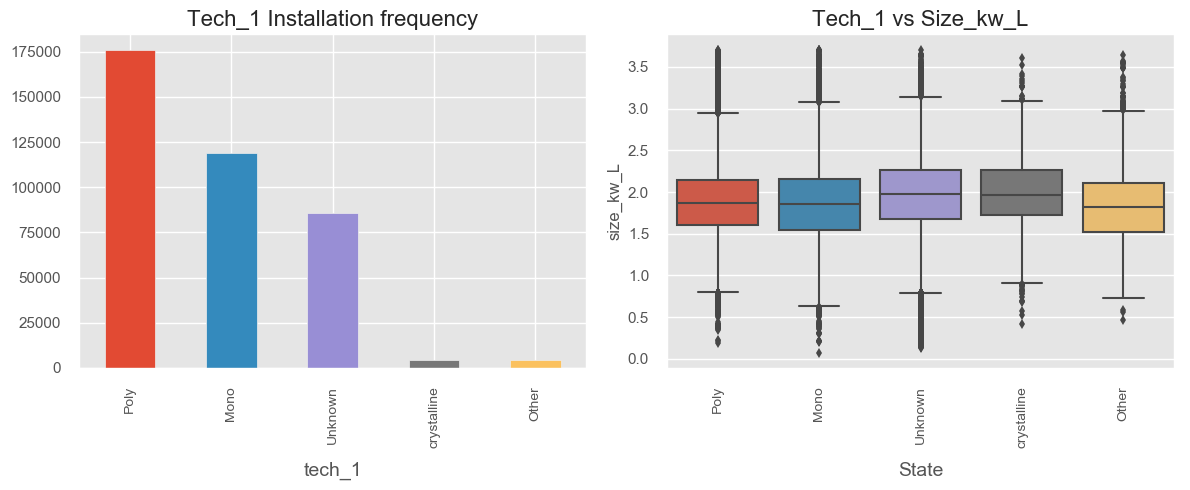

In [34]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='tech_1', sort=True, ascending=False, ax=ax[0], 
                 xlabel='tech_1', title='Tech_1 Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'tech_1', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='Tech_1 vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>

→ The most popular solar panels used for residential setting are `Poly`.  <br>

# `county` county where solar panel has been installed

In [35]:
solar.groupby('county').agg({'size_kw':['mean', 'median', 'size']}).round(2).style.background_gradient(cmap='summer_r')

In [36]:
df.pivot_table(index='county', columns='year', values='size_kw', aggfunc='mean', 
                               fill_value=0).style.background_gradient(cmap='summer_r')

year,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
county,,,,,,,,,,,,,,,,,
Alameda,2.268,0,0,0,0,0,0,0,4.07054,4.13138,4.65204,4.77168,5.01532,4.45818,4.9317,4.45344,4.32621
Bristol,0,0,0,0,0,5.07225,3.96,3.519,2.76,3.92775,4.72252,6.03,6.27936,7.33608,6.88354,7.15753,7.30142
Clark,0,0,0,0,0,3.96,4.49378,5.66342,5.51771,5.52221,5.58688,7.35151,8.0964,7.22381,7.80235,6.53523,6.84506
Contra Costa,0,0,0,0,0,0,0,1.8648,4.64325,4.26698,4.89703,5.54264,5.47879,5.31222,5.73977,5.19463,5.36386
Essex,0,0,0,2.26,2.035,4.43393,5.91056,5.58211,3.10323,4.69788,4.80893,5.55727,6.65203,6.01713,5.79279,6.60787,6.93644
Fresno,0,0,0,0,0,0,0,0,5.91306,5.50125,6.21787,6.62127,5.93419,6.51034,6.88861,4.26614,6.14459
Kern,0,0,0,0,0,0,0,0,5.84494,5.57736,6.59957,6.73685,6.21063,5.93576,6.31047,5.75065,6.0079
Los Angeles,2.4,0,2.82814,4.38648,5.17777,4.55769,4.5066,4.86464,5.29014,5.14298,5.34685,5.36098,5.29088,5.21442,5.47785,5.51871,5.01551
Maricopa,0,0,0,1.73667,2.46922,3.06105,3.18819,4.30267,5.16719,6.09428,6.41567,6.16432,6.25982,7.13297,7.5778,7.99635,8.5674


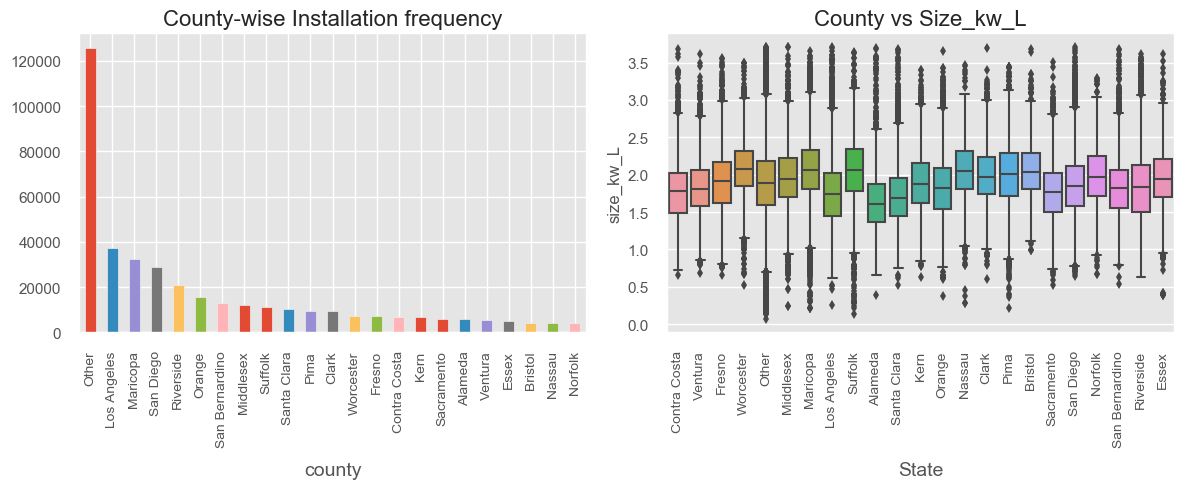

In [37]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='county', sort=True, ascending=False, ax=ax[0], 
                 xlabel='county', title='County-wise Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'county', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='State', 
                     title='County vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>
    
→ Counties that have contributed less than 1% of solar panel installations are aggregated as `others`.

→ LA and Maricopa have installed the most solar panels. <br>

→ Although solar panels have been popular early on in certain counties such as LA, San Diego, Santa Clara (basically CA), 
overall adoption has increased since 2004-2005 in various other counties.

## `incentive_prog_names`: incentive programs for solar panel installation

In [38]:
incentive_prog_names = solar.groupby('incentive_prog_names').agg({'size_kw':['mean', 'median', 'size']})
incentive_prog_names.columns = ['size_mean', 'size_median', 'size_number']
incentive_prog_names.sort_values(by='size_number', ascending=False).style.apply(highlight_max)

,size_mean,size_median,size_number
incentive_prog_names,,,
California Public Utilities Commission (California Solar Initiative),5.77373,5.17,112684
California Public Utilities Commission (Non-CSI Net Metered Systems),5.59563,5.1238,62280
New York State Energy Research and Development Authority,7.43806,6.96,32021
Arizona Public Service,7.16327,6.72,27670
Massachusetts Clean Energy Center,6.5715,6,26482
Massachusetts Department of Energy Resources,7.09861,6.5,18157
Other,5.59428,5.1,15556
Los Angeles Department of Water & Power,5.45507,4.83,14210
California Energy Commission (New Solar Homes Partnership),3.19693,2.4,13379


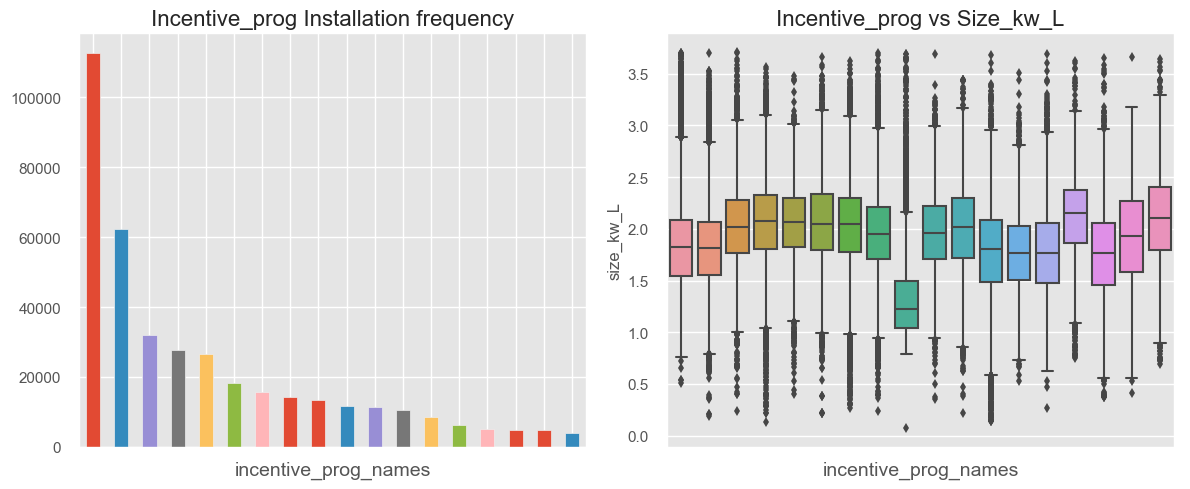

In [39]:
f,ax = plt.subplots(1,2,figsize=(12,5))
# Long names, make plots ugly
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

value_count_plot(data=solar, col='incentive_prog_names', sort=True, ascending=False, ax=ax[0], 
                 xlabel='incentive_prog_names', title='Incentive_prog Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'incentive_prog_names', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='incentive_prog_names', 
                     title='Incentive_prog vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>
    
→ Similar to counties, any incentive programs that have been used in less than 1% of solar panel installations are aggregated as `others`.

→ The most active incentive programs are in CA, as CA was one of the early adopters of clean energy or solar panels. 

## `city`: city of installation

In [40]:
solar.groupby('city').agg({'annual_PV_prod':['mean', 'median', 'size']}).style.apply(highlight_max)

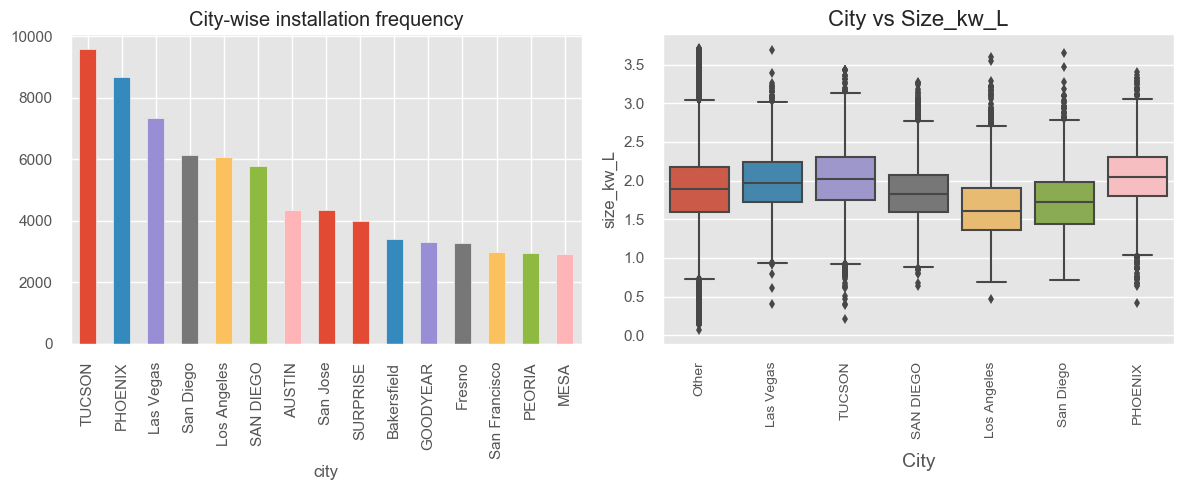

In [41]:
f,ax = plt.subplots(1,2,figsize=(12,5))
# using solar_x data as 'others' will take over
solar_x_city = solar_x.groupby('city').agg({'size_kw':['mean', 'median', 'size']})
solar_x_city.columns = ['size_mean', 'size_median', 'total']
solar_x_city = solar_x_city.sort_values(by = 'total', ascending=False)
solar_x_city = solar_x_city.iloc[:15]
solar_x_city['total'].plot(kind='bar', ax=ax[0])
ax[0].set_title('City-wise installation frequency')

cat_box_plot(x= 'city', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='City', 
                     title='City vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

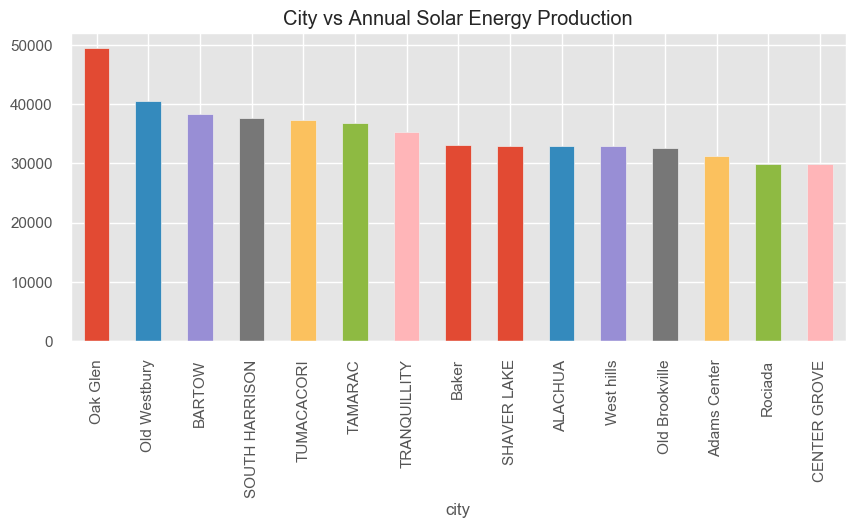

In [42]:
f,ax = plt.subplots(figsize=(10,4))
solar_x_city = solar_x.groupby('city').agg({'annual_PV_prod':['mean', 'median', 'size']})
solar_x_city.columns = ['size_mean', 'size_median', 'total']
solar_x_city = solar_x_city.sort_values(by = 'size_mean', ascending=False)
solar_x_city = solar_x_city.iloc[:15]
solar_x_city['size_mean'].plot(kind='bar')
ax.set_title('City vs Annual Solar Energy Production');

♦ **Initial observation:** <br>
    
→ Similar to counties, any cities that had installed less than 1% of solar panels are aggregated as `others`.

→ The city of Phoenix has installed solar panels with mean highest `size_kw`.

→ The number of installations are highest in Arizona and CA.

→ Cities having the most solar panel installations does NOT mean they produce maximum solar energy. This could be due to various factors. Cities can install more solar panels but with relatively smaller sizes. Or cities with less insolation will produce less solar energy w.r.t. to the city that get more insolation even if they have similar installations.

## `Tracking type`: impacts the efficiency of solar energy production

In [43]:
solar.groupby('tracking_type').agg({'size_kw':['mean', 'median', 'size']}).style.apply(highlight_max)

In [44]:
solar.groupby('tracking_type').agg({'annual_PV_prod':['mean', 'median', 'size']}).style.apply(highlight_max)

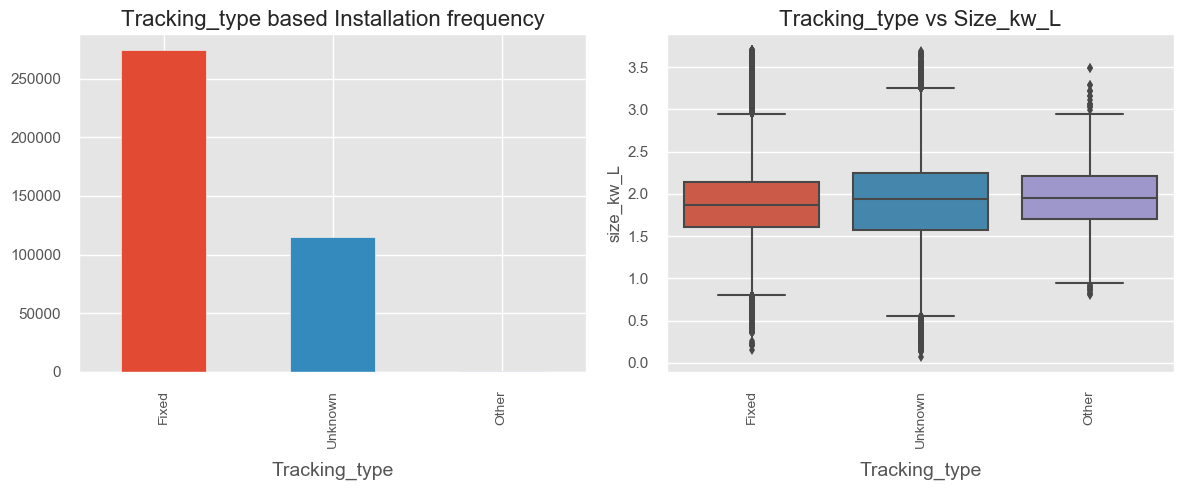

In [45]:
f,ax = plt.subplots(1,2,figsize=(12,5))
value_count_plot(data=solar, col='tracking_type', sort=True, ascending=False, ax=ax[0], 
                 xlabel='Tracking_type', title='Tracking_type based Installation frequency', size= 16, fontsize=10, font=14, rotation=90)

cat_box_plot(x= 'tracking_type', y= 'size_kw_L', data=solar, ax=ax[1], xlabel='Tracking_type', 
                     title='Tracking_type vs Size_kw_L', size=16, fontsize=10, font=14, rotation=90) 

♦ **Initial observation:** <br>
    
→ The most popular `tracking system` is fixed.

→ Overall, `tracking system` does not seem related with `size_kw`.

# Outlier detection

In [46]:
from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 3 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )  
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(solar,1,['size_kw_L', 'annual_PV_prod_L', 'annual_insolation'])
solar.loc[Outliers_to_drop]

,state,date_installed,incentive_prog_names,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,annual_insolation,tracking_type,zipcode_1,year,month,size_kw_L,annual_PV_prod_L


In [47]:
Outliers_to_drop = detect_outliers(solar_val,1,['size_kw_L', 'annual_PV_prod_L', 'annual_insolation'])
solar_val.loc[Outliers_to_drop]

,state,date_installed,incentive_prog_names,size_kw,zipcode,installer,city,tech_1,county,annual_PV_prod,annual_insolation,tracking_type,zipcode_1,year,month,size_kw_L,annual_PV_prod_L


This is end of the data exploration and EDA of the solar data.<br>
→ Part_2 notebook will focus on predicting SolarPanel size prediction.<br>
→ Part_3 notebook will focus on predicting cost of the solar panels.